In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

import matplotlib.font_manager as font_manager

# from matplotlib import rcParams


font = {"family": "Inter"}  # , 'weight': 'normal', 'size': 12}

# Aplica la fuente definida a Matplotlib
plt.rc("font", **font)

sns.set_palette("colorblind")

In [4]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [8]:
# df = run_results_det_optimized


def process_binned(df, max_lim_bin):
    cov_arr = df.cov_array[:, 1:]
    cumulative_times_per_run = (
        vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 1
    )[:, 1:]

    var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(
        cov_arr
    )

    var_arr = np.array(var_arr)
    cumulative_times_per_run = np.array(cumulative_times_per_run)

    no_bins = int(25)
    limites_bins = np.arange(
        0.0,
        max_lim_bin,
        np.floor(max_lim_bin / no_bins),
    )

    all_mean_stds = np.array(
        [
            compute_mean_one_run(
                cumulative_times_per_run[j], cov_arr[j], limites_bins
            )
            for j in range(len(cov_arr))
        ]
    ).swapaxes(0, 1)

    all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]
    all_std_agg_binned = np.nanstd(all_mean_stds, axis=1)[0]
    return all_mean_agg_binned, all_std_agg_binned

In [6]:
larger_prior_results = joblib.load(
    "../results/run_2024-03-08_11:43:55_results.job"
)
larger_prior_model = joblib.load(
    "../results/run_2024-03-08_11:43:55_model.job"
)
m = larger_prior_model


smaller_prior_results = joblib.load(
    "../results/run_2024-03-08_15:22:36_results.job"
)
smaller_prior_model = joblib.load(
    "../results/run_2024-03-08_15:22:36_model.job"
)

In [14]:
smaller_prior_results.times_array.cumsum(axis=1)[:, -1]

Array([1375520.1, 1370594.8], dtype=float32)

In [13]:
larger_prior_results.times_array.cumsum(axis=1)[:, -1]

Array([1393668.4, 1282183.4, 1390561.4], dtype=float32)

In [16]:
max_lim_bin = int(1393668.4 + 1)
mean_larger, std_larger = process_binned(larger_prior_results, max_lim_bin)

/tmp/ipykernel_3551381/313729249.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(cov_arr_i[indices_bins == i], axis=0)
/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [17]:
mean_smaller, std_smaller = process_binned(smaller_prior_results, max_lim_bin)

In [31]:
no_bins = 25
x_times = np.linspace(0, max_lim_bin, len(mean_smaller[:]))

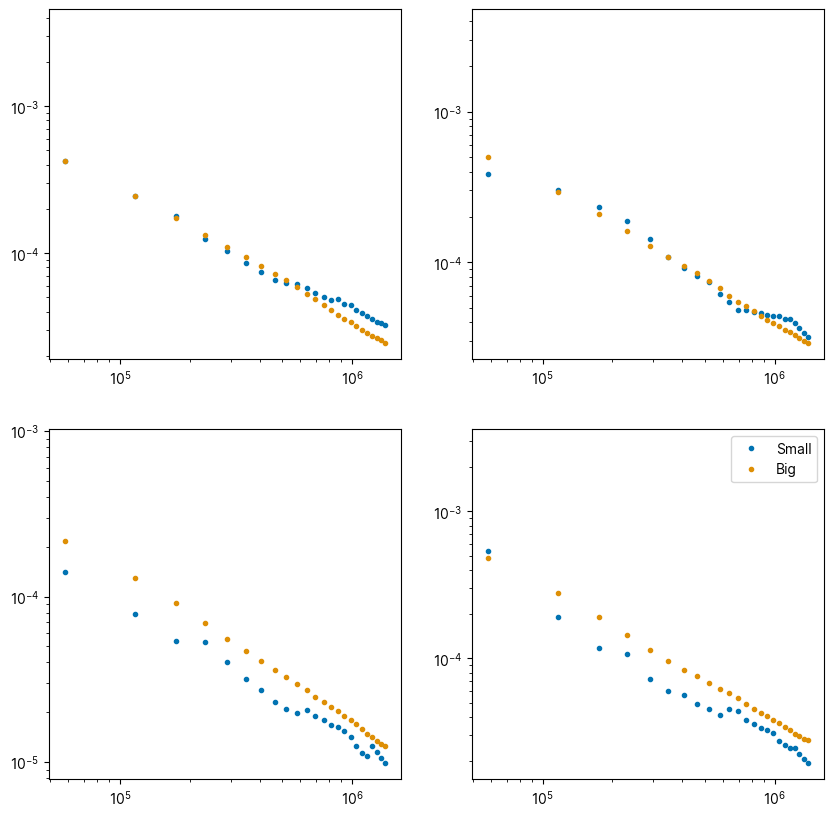

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(x_times, mean_smaller[:, i, i], ".", label="Small")
    ax.plot(x_times, mean_larger[:, i, i], ".", label="Big")
    ax.set_xscale("log")
    ax.set_yscale("log")

plt.legend()
plt.show()

In [26]:
smaller_prior_results

Run(
  iteration=i32[2],
  key=u32[2,2],
  weights=f32[2,500],
  particles_locations=f32[2,500,4],
  max_iterations=i32[2],
  min_iterations=i32[2],
  std_threshold=f32[2],
  cov_array=f32[2,100000,4,4],
  estimates_array=f32[2,100000,4],
  times_array=f32[2,100000]
)

In [25]:
larger_prior_results

Run(
  iteration=i32[3],
  key=u32[3,2],
  weights=f32[3,20000],
  particles_locations=f32[3,20000,4],
  max_iterations=i32[3],
  min_iterations=i32[3],
  std_threshold=f32[3],
  cov_array=f32[3,100000,4,4],
  estimates_array=f32[3,100000,4],
  times_array=f32[3,100000]
)